In [2]:
import os
import sys
sys.path.append('/home/li.yu/code/JupiterCVML/europa/base/src/europa/')

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio

from dl.utils.io_utils import normalize_image
from dl.utils.stereo_camera_parameters import CameraParameters
from dl.utils.write_calib_yaml import CalibDictToYamlWriter
print(cv2.__version__)

4.5.2


In [1]:
import brtdevkit
brtdevkit.MAX_WORKERS

Internal AWS credentials have been removed from brt-devkit.
To setup AWS credentials, Please follow instructions at : https://boto3.amazonaws.com/v1/documentation/api/latest/guide/credentials.html


128

In [22]:
data_folder = '/data2/jupiter/datasets'
dataset = ['halo_humans_on_path_test_v6_2_2_test_dataset',
           'Jupiter_halo_calibration_check_20240122'][0]
dataset_path = f'{data_folder}/{dataset}'
df_master_ann = pd.read_csv(f'{dataset_path}/master_annotations.csv')
df_ann = pd.read_csv(f'{dataset_path}/annotations.csv')

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (23,80,91,92,93,94,95,97,98,100,101,102,103,104,105,106,107,108,118,178,179,185,187,197,198,202,203,204,205,225,230,231,232,235,237,241,252,253,286,287) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (0,1,22,24,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,55,56,57,58,59,60,61,63,64,65,66,67,68,77,87,88,89,90,91,93,94,95,96,97,98,99,100,101,102,103,113,123,124,125,127,129,130,131,132,133,134,135,136,143,146,147,149,151,152,160,161,163,166,167,172,174,184,185,189,190,191,192,195,211,216,217,218,219,221,223,225,236,237,239,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,259,263,264,265,268,269,270,272,274,276,278) have mixed 

In [23]:
df_master_ann[['id', 'id_right', 'camera_location', 'camera_location_right']].head(2)

,id,id_right,camera_location,camera_location_right
0,65036ee63ee8079f7274a26a,65036eee29b2a00f42f01108,T01,T03
1,651f3efbce6a4a1e35ec43f4,651f3f04a99ba5c90714977f,T01,T03


In [24]:
sample_master_ann = df_master_ann.sample(n=1)
sample_ann_left = df_ann[df_ann.id.isin(sample_master_ann.id)]
sample_ann_right = df_ann[df_ann.id.isin(sample_master_ann.id_right)]
sample_master_ann[['id', 'camera_location', 'id_right', 'camera_location_right']]

,id,camera_location,id_right,camera_location_right
12413,65333eea0aa3ae4224ea6ab0,T09,65333ee8ecfeb9d01b7e843d,T11


In [25]:
sample_master_ann = sample_master_ann.iloc[0]
sample_ann_left = sample_ann_left.iloc[0]
sample_ann_right = sample_ann_right.iloc[0]
is_halo = True if sample_master_ann.camera_location in ['T01', 'T02', 'T05', 'T06', 'T09', 'T10', 'T13', 'T14', 'I01', 'I02', 'I05', 'I05'] else False
print(f'is halo data --> {is_halo}')

is halo data --> True


In [26]:
debayered_left_image = imageio.imread(f'{dataset_path}/{sample_ann_left.artifact_debayeredrgb_0_save_path}')
debayered_right_image = imageio.imread(f'{dataset_path}/{sample_ann_right.artifact_debayeredrgb_0_save_path}')
has_label = 'annotation_pixelwise_0_save_path' in sample_ann_left
if has_label:
    debayered_left_label = imageio.imread(f'{dataset_path}/{sample_ann_left.annotation_pixelwise_0_save_path}')
deb_img_h, deb_img_w, _ = debayered_left_image.shape
deb_img_h, deb_img_w, _

(1204, 1944, 3)

In [27]:
stereo = np.load(f'{dataset_path}/{sample_master_ann.stereo_pipeline_npz_save_path}', allow_pickle=True)
rectified_left = normalize_image(stereo['left'], hdr_mode=True)
rectified_right = normalize_image(stereo['right'], hdr_mode=True)
if has_label:
    rectified_left_label = np.load(f'{dataset_path}/{sample_master_ann.rectified_label_save_path}')['left']
if 'rectified_calibration_data' in stereo.files:
    pp_rect_calib = stereo['rectified_calibration_data'].item()
    pp_rect_calib['K1'] = np.array(pp_rect_calib['K1']).reshape(3,3)
    pp_rect_calib['K2'] = np.array(pp_rect_calib['K2']).reshape(3,3)
    pp_rect_calib['D1'] = np.array(pp_rect_calib['D1']).reshape(1,-1)
    pp_rect_calib['D2'] = np.array(pp_rect_calib['D2']).reshape(1,-1)
    pp_rect_calib['R1'] = np.array(pp_rect_calib['R1']).reshape(3,3)
    pp_rect_calib['R2'] = np.array(pp_rect_calib['R2']).reshape(3,3)
    pp_rect_calib['P1'] = np.array(pp_rect_calib['P1']).reshape(3,4)
    pp_rect_calib['P2'] = np.array(pp_rect_calib['P2']).reshape(3,4)
    pp_rect_calib['R'] = np.array(pp_rect_calib['R']).reshape(3,3)
    pp_rect_calib['T'] = np.array(pp_rect_calib['T'])
    pp_rect_calib['Q'] = np.array(pp_rect_calib['Q']).reshape(4,4)

In [38]:
pp_rect_calib

{'K1': array([[1.43944116e+03, 0.00000000e+00, 9.59625000e+02],
        [0.00000000e+00, 1.43944116e+03, 6.13245850e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'K2': array([[1.43564966e+03, 0.00000000e+00, 9.58789490e+02],
        [0.00000000e+00, 1.43564966e+03, 6.15073303e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'D1': array([[-3.99819046e-01,  2.01455548e-01,  2.24288815e-04,
          6.37077756e-05, -5.77287860e-02,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00]]),
 'D2': array([[-4.00639474e-01,  2.03926563e-01, -1.01999598e-04,
          1.05490406e-04, -5.96717633e-02,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00]]),
 'R1': array([[ 0.97101401,  0.08626351, -0.22291343],
        [-0.08798959,  0.99611897,  0.00219632],
        [ 0.22223776,  0.0174814 ,  0.97483577]]),
 'R2': array([[ 0.71177722,  0.24204484, -0.65938417],
        [-0.23654943,  0.96651735,  0.09944133],
        [ 0.6613755 ,  0.08519687

In [28]:
if pd.isnull(sample_master_ann.online_calibration_results):
    left_calib_dict = eval(sample_master_ann.calibration_data)
    right_calib_dict = eval(sample_master_ann.calibration_data_right)
else:
    left_calib_dict = eval(sample_master_ann.online_calibration_results)
    right_calib_dict = eval(sample_master_ann.online_calibration_results_right)

if is_halo:
    cal_dict_obj = CalibDictToYamlWriter(output_dir=os.getcwd())
    debayered_calib_dict = cal_dict_obj.aletheia_calib_dict_to_flat_calib_dict_halo_cameras(left_calib_dict, right_calib_dict)
else:
    debayered_calib_dict = left_calib_dict

In [10]:
def print_dict(dictionary):
    for k,v in dictionary.items():
        print(k,'\n', v, '\n')

In [29]:
if 'left_intrinsics' in debayered_calib_dict:
    left_intrinsics = debayered_calib_dict["left_intrinsics"]
    right_intrinsics = debayered_calib_dict["right_intrinsics"]
    stereo_extrinsics = debayered_calib_dict["stereo_extrinsics"]
    K1 = left_intrinsics["k"]
    K2 = right_intrinsics["k"]
    D1 = left_intrinsics["d"]
    D2 = right_intrinsics["d"]
    R = stereo_extrinsics["r"]
    T = stereo_extrinsics["t"]
    out_image_width, out_image_height = left_intrinsics['width'], left_intrinsics['height']
else:
    K1 = debayered_calib_dict["K1"]
    K2 = debayered_calib_dict["K2"]
    D1 = debayered_calib_dict["D1"]
    D2 = debayered_calib_dict["D2"]
    R = debayered_calib_dict["R"]
    T = debayered_calib_dict["T"]
    out_image_width, out_image_height = sample_master_ann.rectified_stereo_output_width, sample_master_ann.rectified_stereo_output_height


K1 = np.array(K1).reshape(3,3)
K2 = np.array(K2).reshape(3,3)
D1 = np.array(D1).reshape(1,-1)
D2 = np.array(D2).reshape(1,-1)
R = np.array(R).reshape(3,3)
T = np.array(T)

deb_calib = {'K1': K1,
             'K2': K2,
             'D1': D1,
             'D2': D2,
             'R': R,
             'T': T}

In [30]:
rect_img_size = (out_image_width,out_image_height)
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
            deb_calib["K1"],
            deb_calib["D1"],
            deb_calib["K2"],
            deb_calib["D2"],
            (deb_img_w, deb_img_h),
            deb_calib["R"],
            deb_calib["T"],
            flags=0,
            alpha=0,
            newImageSize=(out_image_width,out_image_height)
        )
R1.shape, R2.shape, P1.shape, P2.shape, Q.shape, roi1, roi2

((3, 3), (3, 3), (3, 4), (3, 4), (4, 4), (0, 0, 768, 512), (0, 0, 768, 512))

In [31]:
rect_calib_dict =  {"K1": deb_calib["K1"].copy().astype(np.float32),
                    "K2": deb_calib["K2"].copy().astype(np.float32),
                    "D1": deb_calib["D1"].copy().astype(np.float32),
                    "D2": deb_calib["D2"].copy().astype(np.float32),
                    "R1": R1.astype(np.float32),
                    "R2": R2.astype(np.float32),
                    "T":  T.astype(np.float32),
                    "P1": P1.astype(np.float32),
                    "P2": P2.astype(np.float32),
                    "Q":  Q.astype(np.float32),
                    "image_size": rect_img_size}

In [32]:
print(deb_img_w, deb_img_h)
print(rect_img_size)

1944 1204
(768, 512)


In [33]:
# calib_dict = rect_calib_dict
calib_dict = pp_rect_calib

map1, map2 = cv2.initUndistortRectifyMap(calib_dict['K1'],
                                         calib_dict['D1'],
                                         calib_dict['R1'],
                                         calib_dict['P1'],
                                         (out_image_width, out_image_height),
                                         cv2.CV_32FC1)
cv2_rectified_left_image = cv2.remap(debayered_left_image, map1, map2, cv2.INTER_NEAREST)
if has_label:
    map1, map2 = cv2.initUndistortRectifyMap(calib_dict['K1'],
                                         calib_dict['D1'],
                                         calib_dict['R1'],
                                         calib_dict['P1'],
                                         (out_image_width, out_image_height),
                                         cv2.CV_8UC1)
    cv2_rectified_left_label = cv2.remap(debayered_left_label, map1, map2, cv2.INTER_NEAREST)

map1, map2 = cv2.initUndistortRectifyMap(calib_dict['K2'],
                                         calib_dict['D2'],
                                         calib_dict['R2'],
                                         calib_dict['P2'],
                                         (out_image_width, out_image_height),
                                         cv2.CV_32FC1)
cv2_rectified_right_image = cv2.remap(debayered_right_image, map1, map2, cv2.INTER_NEAREST)

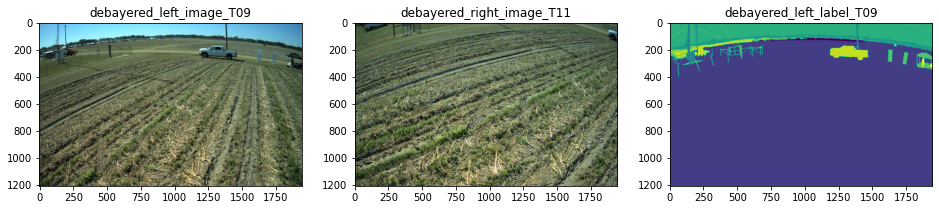

In [34]:
%matplotlib inline
if has_label:
    num_plots = 3
else:
    num_plots = 2
fig, ax = plt.subplots(1, num_plots, figsize=(16,8))
ax[0].imshow(debayered_left_image); ax[0].set_title(f'debayered_left_image_{sample_master_ann.camera_location}')
ax[1].imshow(debayered_right_image); ax[1].set_title(f'debayered_right_image_{sample_master_ann.camera_location_right}')
if has_label:
    ax[2].imshow(debayered_left_label); ax[2].set_title(f'debayered_left_label_{sample_master_ann.camera_location}')
plt.show()
plt.close('all')

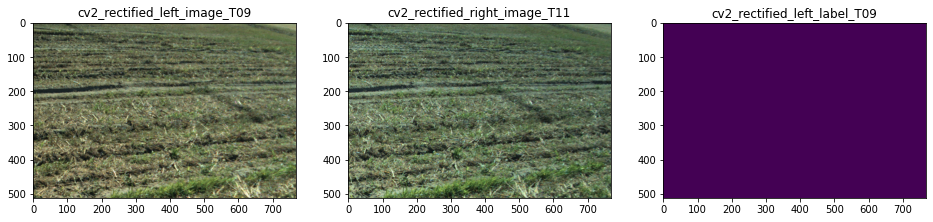

In [35]:
%matplotlib inline
fig, ax = plt.subplots(1, num_plots, figsize=(16,8))
ax[0].imshow(cv2_rectified_left_image); ax[0].set_title(f'cv2_rectified_left_image_{sample_master_ann.camera_location}')
ax[1].imshow(cv2_rectified_right_image); ax[1].set_title(f'cv2_rectified_right_image_{sample_master_ann.camera_location_right}')
if has_label:
    ax[2].imshow(cv2_rectified_left_label); ax[2].set_title(f'cv2_rectified_left_label_{sample_master_ann.camera_location}')
plt.show()
plt.close('all')

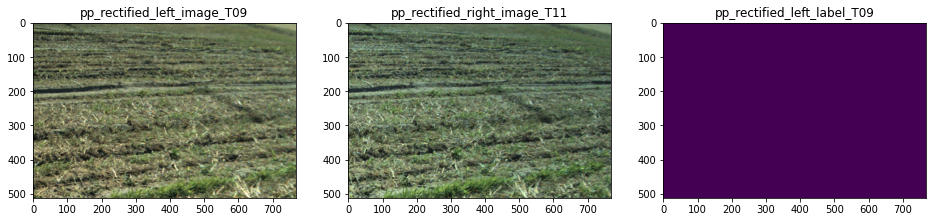

In [36]:
%matplotlib inline
fig, ax = plt.subplots(1, num_plots, figsize=(16,8))
ax[0].imshow(rectified_left); ax[0].set_title(f'pp_rectified_left_image_{sample_master_ann.camera_location}')
ax[1].imshow(rectified_right); ax[1].set_title(f'pp_rectified_right_image_{sample_master_ann.camera_location_right}')
if has_label:
    ax[2].imshow(rectified_left_label); ax[2].set_title(f'pp_rectified_left_label_{sample_master_ann.camera_location}')
plt.show()
plt.close('all')

In [47]:
# clean version of using PP rectification params in cv2 rectification
def read_pp_rect_calib(sample_master_ann, dataset_path):
    stereo = np.load(f'{dataset_path}/{sample_master_ann.stereo_pipeline_npz_save_path}', allow_pickle=True)
    if not 'rectified_calibration_data' in stereo.files:
        print('No rectified_calibration_data in stereo files!')
        return
    pp_rect_calib = stereo['rectified_calibration_data'].item()
    pp_rect_calib['K1'] = np.array(pp_rect_calib['K1']).reshape(3,3)
    pp_rect_calib['K2'] = np.array(pp_rect_calib['K2']).reshape(3,3)
    pp_rect_calib['D1'] = np.array(pp_rect_calib['D1']).reshape(1,-1)
    pp_rect_calib['D2'] = np.array(pp_rect_calib['D2']).reshape(1,-1)
    pp_rect_calib['R1'] = np.array(pp_rect_calib['R1']).reshape(3,3)
    pp_rect_calib['R2'] = np.array(pp_rect_calib['R2']).reshape(3,3)
    pp_rect_calib['P1'] = np.array(pp_rect_calib['P1']).reshape(3,4)
    pp_rect_calib['P2'] = np.array(pp_rect_calib['P2']).reshape(3,4)
    pp_rect_calib['R'] = np.array(pp_rect_calib['R']).reshape(3,3)
    pp_rect_calib['T'] = np.array(pp_rect_calib['T'])
    pp_rect_calib['Q'] = np.array(pp_rect_calib['Q']).reshape(4,4)
    return pp_rect_calib

def run_cv2_rectification_with_pp_calib(unique_id, df_master_ann, df_ann, dataset_path, rectify_left_image=True, rectify_right_image=False, rectify_left_label=False, rectify_right_label=False):
    sample_master_ann = df_master_ann[df_master_ann.unique_id == unique_id].iloc[0]
    sample_ann_left = df_ann[df_ann.id == sample_master_ann.id].iloc[0]
    sample_ann_right = df_ann[df_ann.id == sample_master_ann.id_right].iloc[0]

    # load debayered image and label
    if rectify_left_image:
        input = imageio.imread(f'{dataset_path}/{sample_ann_left.artifact_debayeredrgb_0_save_path}')
    if rectify_right_image:
        input = imageio.imread(f'{dataset_path}/{sample_ann_right.artifact_debayeredrgb_0_save_path}')
    has_label = 'annotation_pixelwise_0_save_path' in sample_ann_left
    if has_label and rectify_left_label:
        input = imageio.imread(f'{dataset_path}/{sample_ann_left.annotation_pixelwise_0_save_path}')

    # read pp rectification calib
    calib_dict = read_pp_rect_calib(sample_master_ann, dataset_path)

    if rectify_left_image:
        K, D, R, P = calib_dict['K1'], calib_dict['D1'], calib_dict['R1'], calib_dict['P1']
        flag = cv2.CV_32FC1
    if rectify_left_label:
        K, D, R, P = calib_dict['K1'], calib_dict['D1'], calib_dict['R1'], calib_dict['P1']
        flag = cv2.CV_8UC1
    if rectify_right_image:
        K, D, R, P = calib_dict['K2'], calib_dict['D2'], calib_dict['R2'], calib_dict['P2']
        flag = cv2.CV_32FC1
    if rectify_right_label:
        K, D, R, P = calib_dict['K2'], calib_dict['D2'], calib_dict['R2'], calib_dict['P2']
        flag = cv2.CV_8UC1
    map1, map2 = cv2.initUndistortRectifyMap(K, D, R, P,
                                            calib_dict['image_size'],
                                            flag)

    output = cv2.remap(input, map1, map2, cv2.INTER_NEAREST)
    return output


def run_cv2_rectification_with_pp_calib_on_right_label(unique_id, df_master_ann, dataset_path, debayered_left_label):
    sample_master_ann = df_master_ann[df_master_ann.unique_id == unique_id].iloc[0]

    calib_dict = read_pp_rect_calib(sample_master_ann, dataset_path)
    K, D, R, P = calib_dict['K1'], calib_dict['D1'], calib_dict['R1'], calib_dict['P1']
    flag = cv2.CV_8UC1
    map1, map2 = cv2.initUndistortRectifyMap(K, D, R, P,
                                            calib_dict['image_size'],
                                            flag)

    output = cv2.remap(debayered_left_label, map1, map2, cv2.INTER_NEAREST)
    return output


is halo data --> True


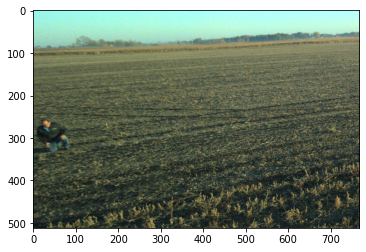

is halo data --> True


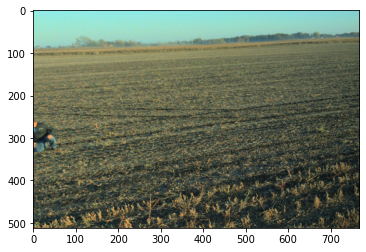

is halo data --> True


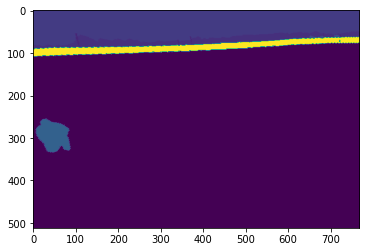

In [46]:
unique_id = df_master_ann.sample(1).iloc[0].unique_id
output = run_cv2_rectification_with_pp_calib(unique_id, df_master_ann, df_ann, dataset_path, True, False, False, False)
plt.imshow(output)
plt.show()
output = run_cv2_rectification_with_pp_calib(unique_id, df_master_ann, df_ann, dataset_path, False, True, False, False)
plt.imshow(output)
plt.show()
output = run_cv2_rectification_with_pp_calib(unique_id, df_master_ann, df_ann, dataset_path, False, False, True, False)
plt.imshow(output)
plt.show()

In [50]:
debayered_left_label.shape

(1204, 1944)

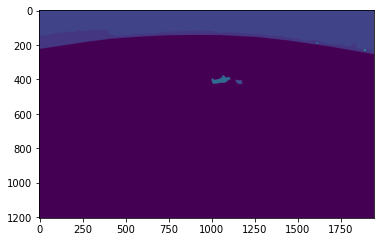

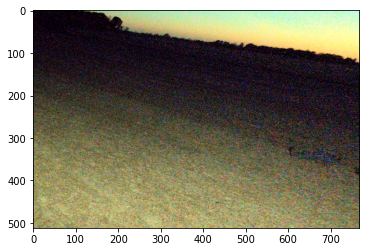

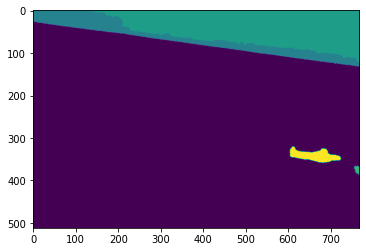

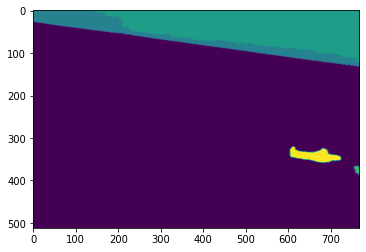

In [49]:
unique_id = df_master_ann.sample(1).iloc[0].unique_id
sample_master_ann = df_master_ann[df_master_ann.unique_id == unique_id].iloc[0]
sample_ann_left = df_ann[df_ann.id == sample_master_ann.id].iloc[0]
debayered_left_label = imageio.imread(f'{dataset_path}/{sample_ann_left.annotation_pixelwise_0_save_path}')
stereo = np.load(f'{dataset_path}/{sample_master_ann.stereo_pipeline_npz_save_path}', allow_pickle=True)
rectified_left = normalize_image(stereo['left'], hdr_mode=True)
rectified_left_label = np.load(f'{dataset_path}/{sample_master_ann.rectified_label_save_path}')['left']

cv2_rectified_left_label = run_cv2_rectification_with_pp_calib_on_right_label(unique_id, df_master_ann, dataset_path, debayered_left_label)
plt.imshow(debayered_left_label)
plt.show()
plt.imshow(rectified_left)
plt.show()
plt.imshow(rectified_left_label)
plt.show()
plt.imshow(cv2_rectified_left_label)
plt.show()

In [28]:
for k,v in pp_rect_calib.items():
    if k in rect_calib_dict:
        print(f'rect_calib_dict --> {k}')
        print(rect_calib_dict[k])
        print('\n')
    if k in pp_rect_calib:
        print(f'pp_rect_calib --> {k}')
        print(pp_rect_calib[k])
        print('\n')
    if k in deb_calib:
        print(f'deb_calib --> {k}')
        print(deb_calib[k])
    print('\n\n')

rect_calib_dict --> K1
[[1.4357396e+03 0.0000000e+00 9.7505719e+02]
 [0.0000000e+00 1.4357396e+03 6.1549829e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]


pp_rect_calib --> K1
[[1.43573962e+03 0.00000000e+00 9.75057190e+02]
 [0.00000000e+00 1.43573962e+03 6.15498291e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


deb_calib --> K1
[[1.43573962e+03 0.00000000e+00 9.75057190e+02]
 [0.00000000e+00 1.43573962e+03 6.15498291e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]



rect_calib_dict --> K2
[[1.4384238e+03 0.0000000e+00 9.7023578e+02]
 [0.0000000e+00 1.4384238e+03 6.1726141e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]


pp_rect_calib --> K2
[[1.43842383e+03 0.00000000e+00 9.70235779e+02]
 [0.00000000e+00 1.43842383e+03 6.17261414e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


deb_calib --> K2
[[1.43842383e+03 0.00000000e+00 9.70235779e+02]
 [0.00000000e+00 1.43842383e+03 6.17261414e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]



rect_calib_d